## **Emotion Detection with Transfer Learning Techniques**

In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Objectives:**

1. To explore the potential of transfer learning in improving the performance of emotion detection from facial expressions.
2. To implement and evaluate a transfer learning approach for emotion detection from facial expressions using TensorFlow and Keras.
3. To fine-tune a pre-trained deep learning model (ResNet50) on a specific emotion detection dataset and compare its performance with traditional feature-based methods such as Local Binary Patterns (LBP) and Histogram of Oriented Gradients (HOG), and other deep learning models such as CNNs and RNNs.
4. To identify challenges and opportunities in emotion detection from facial expressions using transfer learning techniques and highlight future research directions.


## **STEP 1: Data Preparation**

**Import the relevant libraries used for the project**

**List all the classes from the directories**

In [38]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [39]:
dataset_path = '/kaggle/input/emotion-detection-fer/'
labels = os.listdir(dataset_path)
labels


['test', 'train']

**Determine the number of classes within every classification.**

In [40]:
for label in labels:
    print(label, len(os.listdir(dataset_path+'/'+label)))
    

test 7
train 7


In [41]:
# Define the paths to the dataset directories
train_dir = '/kaggle/input/emotion-detection-fer/train/'
test_dir = '/kaggle/input/emotion-detection-fer/test/'

# Define emotions
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


**Identify the number of images in each category**

In [42]:
# Count the number of images in each category for the training set
train_counts = []
for emotion in emotions:
    train_counts.append(len(os.listdir(train_dir + emotion)))
print("Training set:")
for i in range(len(emotions)):
    print(emotions[i] + ": " + str(train_counts[i]))

# Count the number of images in each category for the test set
test_counts = []
for emotion in emotions:
    test_counts.append(len(os.listdir(test_dir + emotion)))
print("\nTest set:")
for i in range(len(emotions)):
    print(emotions[i] + ": " + str(test_counts[i]))


Training set:
angry: 3995
disgusted: 436
fearful: 4097
happy: 7215
neutral: 4965
sad: 4830
surprised: 3171

Test set:
angry: 958
disgusted: 111
fearful: 1024
happy: 1774
neutral: 1233
sad: 1247
surprised: 831


**Using Matplotlib, display a sample image from every category.**

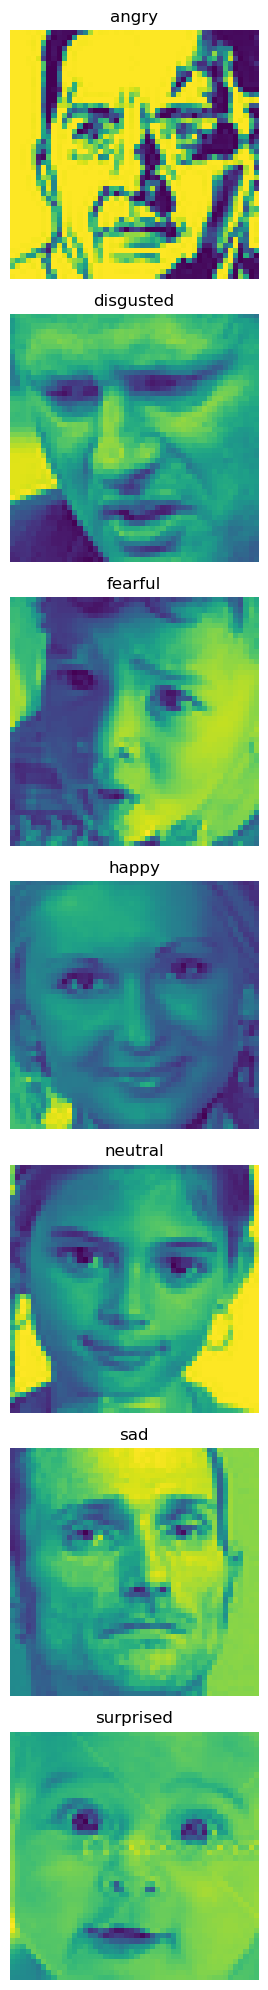

In [7]:
# Create a figure and axis object for each class
fig, ax = plt.subplots(nrows=len(emotions), ncols=1, figsize=(5,20))

# Loop through each class and display an example image
for i, emotion in enumerate(emotions):
    # Find the first image belonging to the current class in the training set
    image_path = f"{train_dir}/{emotion}/" + os.listdir(f"{train_dir}/{emotion}")[0]
    # Load the image and display it
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].set_title(emotion)
    ax[i].axis('off')

# Display the figure
plt.tight_layout()
plt.show()



In [43]:
# Create batches from the train and test directories
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size,
    batch_size=batch_size, 
    class_mode='categorical', shuffle=True, subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size,
    batch_size=batch_size, 
    class_mode='categorical', shuffle=True, subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical', shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Let us show some of the images created from the generator:**

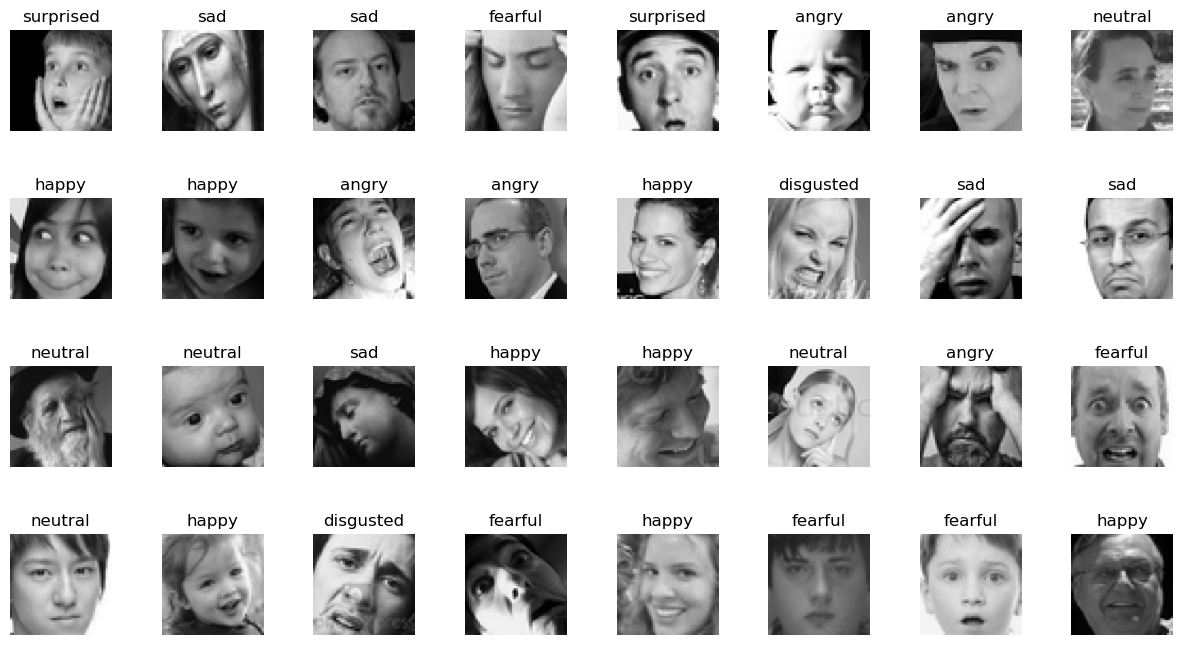

In [44]:
# Get a batch of images and labels from the generator
x_batch, y_batch = next(train_generator)

# Get the emotion labels from the generator class indices
emotion_labels = list(train_generator.class_indices.keys())

# Plot the images and labels
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in np.arange(0, 4*8):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    emotion_idx = np.argmax(y_batch[i])
    axes[i].set_title(emotion_labels[emotion_idx])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


## **Split the data into training and validation sets**

In [45]:
# Prepare the target labels by one-hot encoding the categorical labels
num_classes = len(emotions)

In [46]:
# Split the data into training and validation sets
train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_generator[0][0], 
    train_generator[0][1], 
    test_size=0.2, 
    random_state=13
)

In [47]:
# Convert the images and labels to numpy arrays
train_images = train_images.astype('float32')
validation_images = validation_images.astype('float32')
train_labels = to_categorical(train_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)


In [48]:
# Print the shape of the training and validation sets
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Images Shape: {validation_images.shape}")
print(f"Validation Labels Shape: {validation_labels.shape}")


Training Images Shape: (25, 224, 224, 3)
Training Labels Shape: (25, 7, 7)
Validation Images Shape: (7, 224, 224, 3)
Validation Labels Shape: (7, 7, 7)


In [49]:
# Print the shape of the testing set
test_images = test_generator[0][0].astype('float32')
test_labels = to_categorical(test_generator[0][1], num_classes)
print(f"Testing Images Shape: {test_images.shape}")
print(f"Testing Labels Shape: {test_labels.shape}")


Testing Images Shape: (32, 224, 224, 3)
Testing Labels Shape: (32, 7, 7)


## **STEP 2: Building the Model**

### **TRANSFER LEARNING USING VGG16 TECHNIQUE**

In [50]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers

In [142]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [143]:
# Freeze the layers of the pre-trained VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

In [144]:
# Add additional layers to the model
x = Flatten()(vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [145]:
model_1 = Model(vgg16.input, x)

In [146]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [147]:
# Train the model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 131s 172ms/step - loss: 1.4704 - accuracy: 0.4378 - val_loss: 1.3351 - val_accuracy: 0.4989
Epoch 2/30
718/718 [==============================] - 117s 162ms/step - loss: 1.2304 - accuracy: 0.5386 - val_loss: 1.3356 - val_accuracy: 0.4849
Epoch 3/30
718/718 [==============================] - 117s 163ms/step - loss: 1.1187 - accuracy: 0.5844 - val_loss: 1.2970 - val_accuracy: 0.5144
Epoch 4/30
718/718 [==============================] - 117s 163ms/step - loss: 1.0435 - accuracy: 0.6144 - val_loss: 1.2496 - val_accuracy: 0.5283
Epoch 5/30
718/718 [==============================] - 117s 163ms/step - loss: 0.9657 - accuracy: 0.6486 - val_loss: 1.2932 - val_accuracy: 0.5208
Epoch 6/30
718/718 [==============================] - 117s 163ms/step - loss: 0.9021 - accuracy: 0.6700 - val_loss: 1.2871 - val_accuracy: 0.5320
Epoch 7/30
718/718 [==============================] - 117s 163ms/step - loss: 0.8344 - accuracy: 0.7017 - val_loss: 1.3164 -

#### **Fine tune the model to improve accuracy by adding data argumentation**

In [148]:
# Load the pre-trained VGG16 model
base_model_2 = VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [149]:
# Unfreeze some of the deeper layers for fine-tuning
for layer in base_model_2.layers[:-10]:
    layer.trainable = False

In [150]:
# Add additional layers to the model
x = Flatten()(base_model_2.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [151]:
model_2 = Model(inputs=base_model_2.input, outputs=x)

In [152]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [153]:
# Train the model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 188s 255ms/step - loss: 1.5723 - accuracy: 0.3753 - val_loss: 1.3184 - val_accuracy: 0.4868
Epoch 2/30
718/718 [==============================] - 184s 257ms/step - loss: 1.2204 - accuracy: 0.5302 - val_loss: 1.1759 - val_accuracy: 0.5453
Epoch 3/30
718/718 [==============================] - 184s 257ms/step - loss: 1.0784 - accuracy: 0.5897 - val_loss: 1.0982 - val_accuracy: 0.5815
Epoch 4/30
718/718 [==============================] - 184s 257ms/step - loss: 0.9587 - accuracy: 0.6386 - val_loss: 1.0818 - val_accuracy: 0.5988
Epoch 5/30
718/718 [==============================] - 184s 257ms/step - loss: 0.8378 - accuracy: 0.6872 - val_loss: 1.0604 - val_accuracy: 0.6105
Epoch 6/30
718/718 [==============================] - 184s 257ms/step - loss: 0.7023 - accuracy: 0.7393 - val_loss: 1.1252 - val_accuracy: 0.6110
Epoch 7/30
718/718 [==============================] - 185s 258ms/step - loss: 0.5513 - accuracy: 0.7995 - val_loss: 1.1639 -

## **Let us try to add dropout and also  freeze all layers except the last block of the VGG16 model**


In [154]:
# Load the pre-trained VGG16 model
vgg16_3 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


In [155]:
# Freeze the layers of the pre-trained VGG16 model except the last block
for layer in vgg16_3.layers[:-4]:
    layer.trainable = False

In [156]:
# Add additional layers to the model
x = Flatten()(vgg16_3.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Add another dropout regularization
x = Dense(num_classes, activation='softmax')(x)

In [157]:
# Create the fine-tuned model
model_3 = Model(inputs=vgg16_3.input, outputs=x)

In [158]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [159]:
# Train the model
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 132s 181ms/step - loss: 1.3790 - accuracy: 0.4639 - val_loss: 1.2058 - val_accuracy: 0.5400
Epoch 2/30
718/718 [==============================] - 132s 184ms/step - loss: 1.1243 - accuracy: 0.5739 - val_loss: 1.1047 - val_accuracy: 0.5752
Epoch 3/30
718/718 [==============================] - 132s 184ms/step - loss: 0.9782 - accuracy: 0.6320 - val_loss: 1.0568 - val_accuracy: 0.6048
Epoch 4/30
718/718 [==============================] - 132s 184ms/step - loss: 0.8439 - accuracy: 0.6852 - val_loss: 1.0616 - val_accuracy: 0.6150
Epoch 5/30
718/718 [==============================] - 132s 184ms/step - loss: 0.6905 - accuracy: 0.7478 - val_loss: 1.1063 - val_accuracy: 0.6220
Epoch 6/30
718/718 [==============================] - 132s 184ms/step - loss: 0.5396 - accuracy: 0.8024 - val_loss: 1.2239 - val_accuracy: 0.6258
Epoch 7/30
718/718 [==============================] - 132s 184ms/step - loss: 0.3843 - accuracy: 0.8615 - val_loss: 1.4384 -

### **Compare the three models**

In [77]:
import matplotlib.pyplot as plt

In [160]:

# Extract validation accuracy values from training history
accuracy_model_1 = history_1.history['val_accuracy']
accuracy_model_2 = history_2.history['val_accuracy']
accuracy_model_3 = history_3.history['val_accuracy']

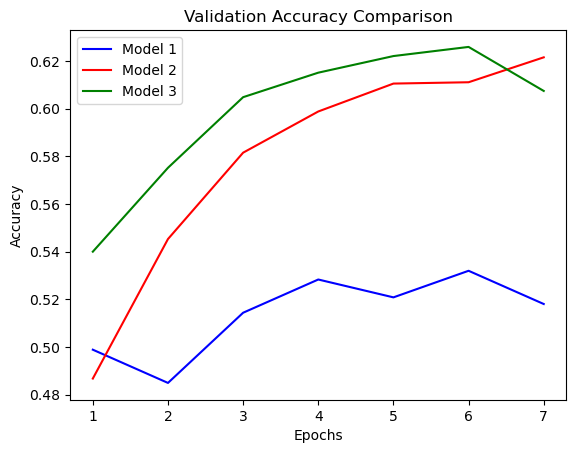

In [164]:
min_epochs = min(len(accuracy_model_1), len(accuracy_model_2), len(accuracy_model_3))
epochs = range(1, min_epochs + 1)

plt.plot(epochs, accuracy_model_1[:min_epochs], 'b', label='Model 1')
plt.plot(epochs, accuracy_model_2[:min_epochs], 'r', label='Model 2')
plt.plot(epochs, accuracy_model_3[:min_epochs], 'g', label='Model 3')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### **Graphical comparison for the test accuracy of the three models**

225/225 [==============================] - 29s 127ms/step - loss: 1.0657 - accuracy: 0.5945


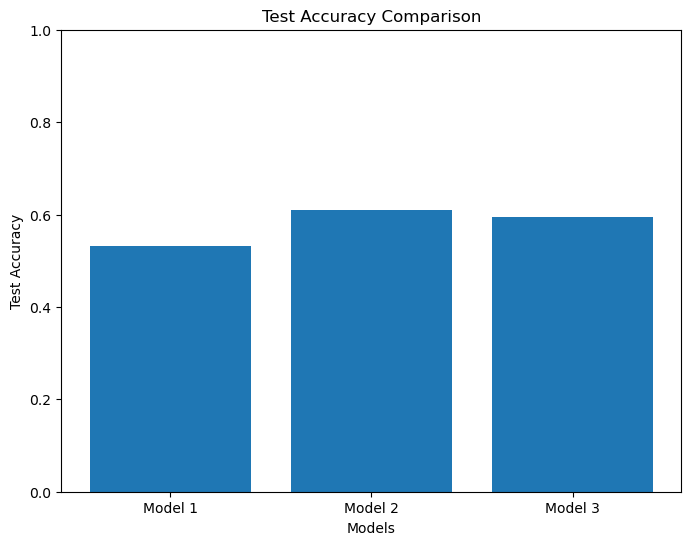

In [169]:

# Evaluate model 1
test_loss1, test_accuracy1 = model_1.evaluate(test_generator)

# Evaluate model 2
test_loss2, test_accuracy2 = model_2.evaluate(test_generator)

# Evaluate model 3
test_loss3, test_accuracy3 = model_3.evaluate(test_generator)

# Create a bar plot for test accuracy
models = ['Model 1', 'Model 2', 'Model 3']
test_accuracies = [test_accuracy1, test_accuracy2, test_accuracy3]

plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies)
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])
plt.show()


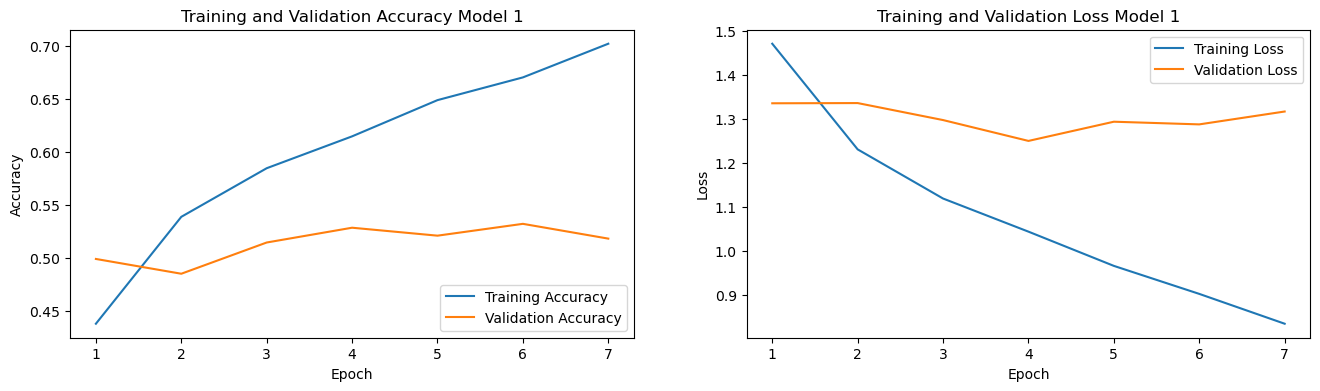

In [173]:
# Get the accuracy and loss values from the training history
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 1')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 1')

# Display the figure
plt.show()


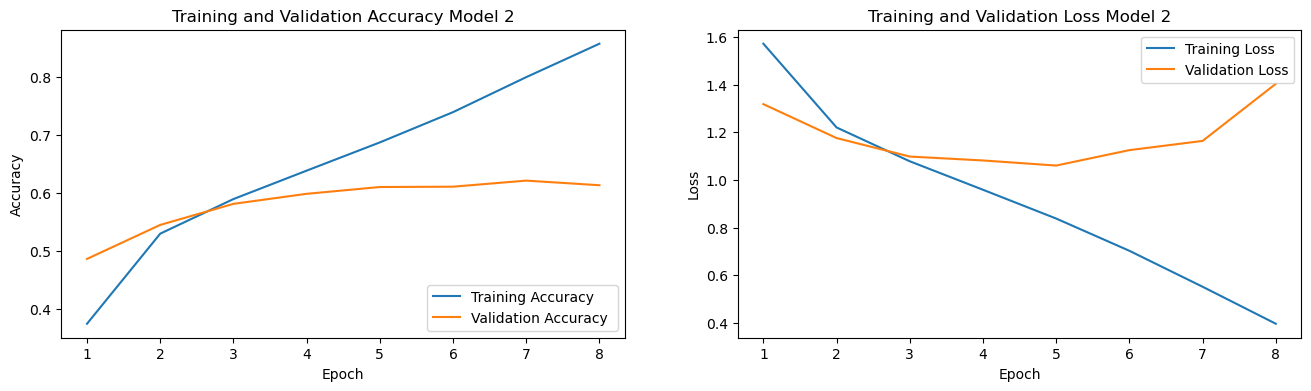

In [172]:
# Get the accuracy and loss values from the training history
train_acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 2')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 2')

# Display the figure
plt.show()


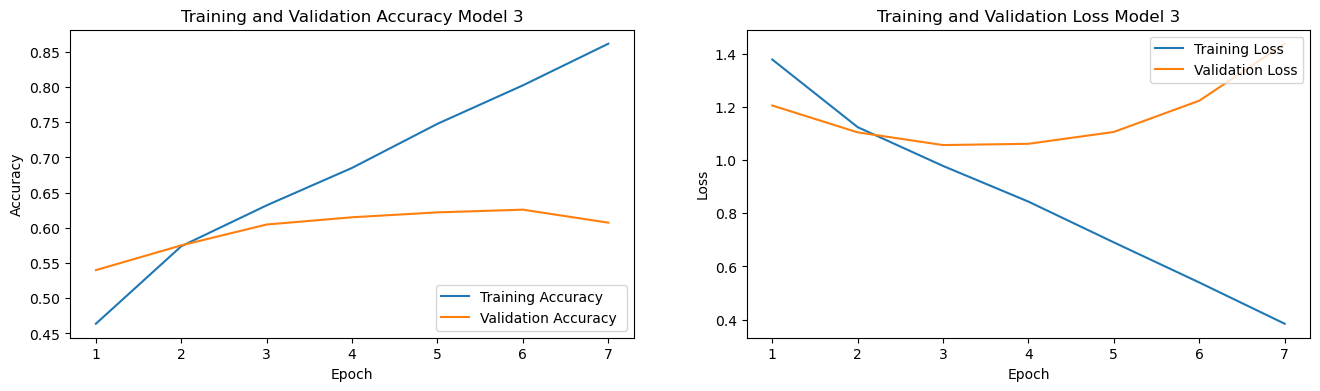

In [174]:
# Get the accuracy and loss values from the training history
train_acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
train_loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 3')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 3')

# Display the figure
plt.show()


In [178]:
# Generate predictions for model 1
model1_predictions = model_1.predict(test_generator)
model1_predicted_labels = np.argmax(model1_predictions, axis=1)

# Generate predictions for model 2
model2_predictions = model_2.predict(test_generator)
model2_predicted_labels = np.argmax(model2_predictions, axis=1)

# Generate predictions for model 3
model3_predictions = model_3.predict(test_generator)
model3_predicted_labels = np.argmax(model3_predictions, axis=1)



225/225 [==============================] - 27s 118ms/step


In [180]:
from sklearn.metrics import classification_report

# Calculate performance metrics for model 1
model1_metrics = classification_report(test_generator.classes, model1_predicted_labels, target_names=emotions, zero_division=1)

# Calculate performance metrics for model 2
model2_metrics = classification_report(test_generator.classes, model2_predicted_labels, target_names=emotions, zero_division=1)

# Calculate performance metrics for model 3
model3_metrics = classification_report(test_generator.classes, model3_predicted_labels, target_names=emotions, zero_division=1)


# Print performance metrics for each model
print("Model 1 Metrics:")
print(model1_metrics)

print("Model 2 Metrics:")
print(model2_metrics)

print("Model 3 Metrics:")
print(model3_metrics)



Model 1 Metrics:
              precision    recall  f1-score   support

       angry       0.51      0.42      0.46       958
   disgusted       0.94      0.15      0.26       111
     fearful       0.32      0.50      0.39      1024
       happy       0.79      0.72      0.76      1774
     neutral       0.61      0.33      0.43      1233
         sad       0.38      0.55      0.45      1247
   surprised       0.76      0.62      0.68       831

    accuracy                           0.53      7178
   macro avg       0.62      0.47      0.49      7178
weighted avg       0.58      0.53      0.54      7178

Model 2 Metrics:
              precision    recall  f1-score   support

       angry       0.61      0.43      0.50       958
   disgusted       0.55      0.35      0.43       111
     fearful       0.52      0.25      0.34      1024
       happy       0.82      0.85      0.83      1774
     neutral       0.60      0.55      0.58      1233
         sad       0.41      0.65      0.50 

### **Visualize a few test images with their predicted classes for Model 2**

1/1 [==============================] - 0s 161ms/step


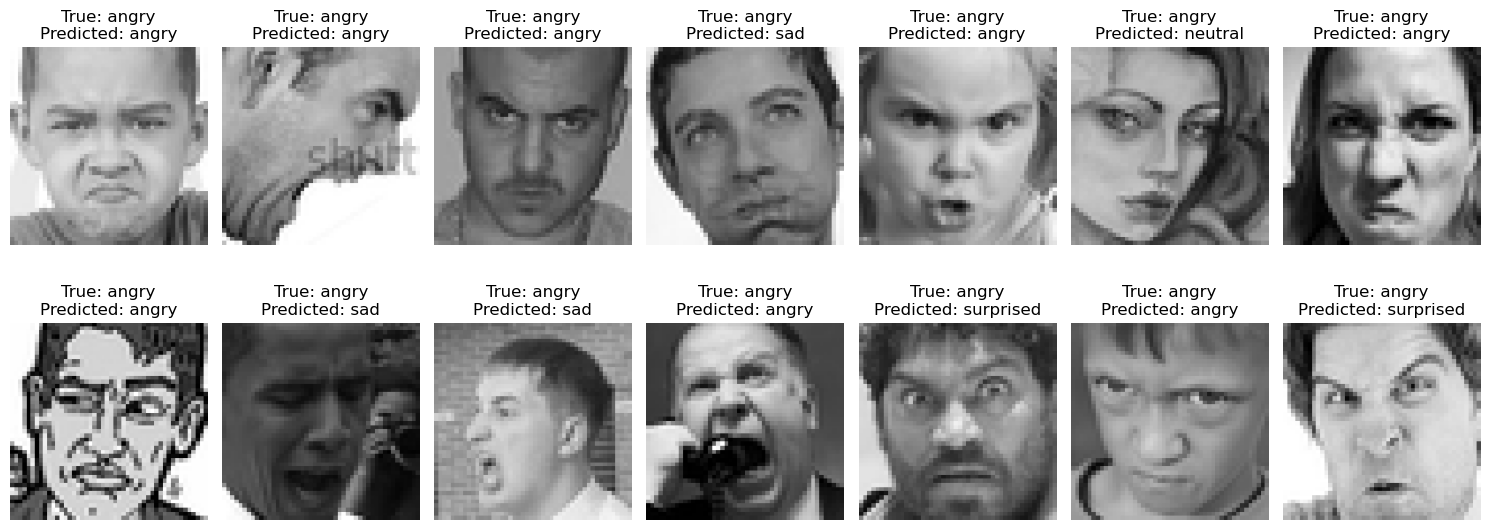

In [181]:
import matplotlib.pyplot as plt
import numpy as np

# Get test images and their corresponding labels
test_images = test_generator[0][0]
test_labels = test_generator[0][1]
predicted_labels = model_2.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Define the class labels
class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Select 14 random images to visualize
num_images = 14
random_indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Plot the test images with their predicted classes
fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i, index in enumerate(random_indices):
    img = test_images[index]
    label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]
    
    row = i // 7
    col = i % 7
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {label}\nPredicted: {predicted_label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### **TRANSFER LEARNING USING ResNet50 TECHNIQUE**

In [26]:
# Import the ResNet50 model from tensorflow.keras.applications:

from tensorflow.keras.applications.resnet50 import ResNet50  


In [27]:
conv_base = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False) 


94765736/94765736 [==============================] - 1s 0us/step


In [28]:
# Freeze the layers of the ResNet50 model:

for layer in conv_base.layers:
    layer.trainable = False


In [29]:
# Add additional layers to the model

x = Flatten()(conv_base.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model1 = Model(conv_base.input, x)


In [30]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [31]:
# Train the model
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_model1 = model1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)


Epoch 1/30
718/718 [==============================] - 244s 318ms/step - loss: 1.9264 - accuracy: 0.2555 - val_loss: 1.7460 - val_accuracy: 0.2693
Epoch 2/30
718/718 [==============================] - 107s 149ms/step - loss: 1.7308 - accuracy: 0.3174 - val_loss: 1.6570 - val_accuracy: 0.3423
Epoch 3/30
718/718 [==============================] - 109s 151ms/step - loss: 1.6797 - accuracy: 0.3401 - val_loss: 1.5962 - val_accuracy: 0.3909
Epoch 4/30
718/718 [==============================] - 108s 151ms/step - loss: 1.6564 - accuracy: 0.3470 - val_loss: 1.6634 - val_accuracy: 0.3421
Epoch 5/30
718/718 [==============================] - 108s 151ms/step - loss: 1.6304 - accuracy: 0.3579 - val_loss: 1.6459 - val_accuracy: 0.3370
Epoch 6/30
718/718 [==============================] - 108s 151ms/step - loss: 1.6037 - accuracy: 0.3695 - val_loss: 1.6185 - val_accuracy: 0.3752
Epoch 7/30
718/718 [==============================] - 109s 152ms/step - loss: 1.5842 - accuracy: 0.3812 - val_loss: 1.6740 -

#### **Fine tune the model to improve accuracy by adding data argumentation**

In [42]:
# Load the pre-trained VGG16 model
base_model2 = ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [43]:
# Unfreeze some of the deeper layers for fine-tuning
for layer in base_model2.layers[:-6]:
    layer.trainable = False

In [44]:
# Add additional layers to the model
x = Flatten()(base_model2.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  
x = Dense(num_classes, activation='softmax')(x)


model2 = Model(base_model2.input, x)


In [45]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

#model2.summary()

In [46]:
# Train the model
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_model2 = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 119s 160ms/step - loss: 1.8402 - accuracy: 0.2963 - val_loss: 1.6516 - val_accuracy: 0.3588
Epoch 2/30
718/718 [==============================] - 113s 157ms/step - loss: 1.6274 - accuracy: 0.3572 - val_loss: 1.6855 - val_accuracy: 0.3266
Epoch 3/30
718/718 [==============================] - 114s 158ms/step - loss: 1.5797 - accuracy: 0.3777 - val_loss: 1.6272 - val_accuracy: 0.3656
Epoch 4/30
718/718 [==============================] - 115s 160ms/step - loss: 1.5453 - accuracy: 0.3992 - val_loss: 1.5595 - val_accuracy: 0.4102
Epoch 5/30
718/718 [==============================] - 114s 158ms/step - loss: 1.5220 - accuracy: 0.4067 - val_loss: 1.5216 - val_accuracy: 0.4215
Epoch 6/30
718/718 [==============================] - 114s 158ms/step - loss: 1.4929 - accuracy: 0.4244 - val_loss: 1.4924 - val_accuracy: 0.4275
Epoch 7/30
718/718 [==============================] - 113s 157ms/step - loss: 1.4716 - accuracy: 0.4320 - val_loss: 1.4944 -

## **Let us try to add dropout and also  freeze all layers except the last block of the ResNet model**

In [59]:
# Load the pre-trained ResNet50 model
base_model3 = ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [60]:
# Add additional layers to the model
x = GlobalAveragePooling2D()(base_model3.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Add another dropout regularization
x = Dense(num_classes, activation='softmax',
          kernel_regularizer=regularizers.l2(0.01))(x)

model3 = Model(base_model3.input, x)


In [61]:

# Compile the model

optimizer = Adam(learning_rate=1e-4)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



In [62]:
# Train the model
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_model3 = model3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 297s 371ms/step - loss: 1.3536 - accuracy: 0.5333 - val_loss: 1.7740 - val_accuracy: 0.3209
Epoch 2/30
718/718 [==============================] - 271s 378ms/step - loss: 0.9921 - accuracy: 0.6692 - val_loss: 1.2259 - val_accuracy: 0.5806
Epoch 3/30
718/718 [==============================] - 271s 377ms/step - loss: 0.7468 - accuracy: 0.7547 - val_loss: 1.0794 - val_accuracy: 0.6361
Epoch 4/30
718/718 [==============================] - 271s 377ms/step - loss: 0.5270 - accuracy: 0.8329 - val_loss: 1.4192 - val_accuracy: 0.6211
Epoch 5/30
718/718 [==============================] - 270s 376ms/step - loss: 0.3512 - accuracy: 0.8956 - val_loss: 1.4899 - val_accuracy: 0.5992
Epoch 6/30
718/718 [==============================] - 271s 377ms/step - loss: 0.2574 - accuracy: 0.9263 - val_loss: 1.6002 - val_accuracy: 0.6337
Epoch 7/30
718/718 [==============================] - 271s 377ms/step - loss: 0.2074 - accuracy: 0.9410 - val_loss: 1.7259 -

In [95]:
# Load the pre-trained ResNet50 model
base_model4 = ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [96]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers

# Add additional layers to the model
x = GlobalAveragePooling2D()(base_model4.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout regularization
x = BatchNormalization()(x)  # Add batch normalization
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)  # Add another dropout regularization
x = BatchNormalization()(x)  # Add batch normalization
x = Dense(num_classes, activation='softmax',
          kernel_regularizer=regularizers.l2(0.01))(x)


model4 = Model(base_model4.input, x)

In [97]:

# Compile the model

optimizer = Adam(learning_rate=1e-4)
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



In [98]:
# Train the model
early_stop = EarlyStopping(patience=4, restore_best_weights=True)
history_model4 = model4.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop]
)

Epoch 1/30
718/718 [==============================] - 407s 522ms/step - loss: 1.6742 - accuracy: 0.4620 - val_loss: 1.9135 - val_accuracy: 0.3322
Epoch 2/30
718/718 [==============================] - 267s 372ms/step - loss: 1.1720 - accuracy: 0.6173 - val_loss: 1.2397 - val_accuracy: 0.5874
Epoch 3/30
718/718 [==============================] - 270s 376ms/step - loss: 0.9370 - accuracy: 0.6973 - val_loss: 1.4064 - val_accuracy: 0.5628
Epoch 4/30
718/718 [==============================] - 270s 375ms/step - loss: 0.7395 - accuracy: 0.7660 - val_loss: 1.3233 - val_accuracy: 0.5954
Epoch 5/30
718/718 [==============================] - 270s 376ms/step - loss: 0.5562 - accuracy: 0.8329 - val_loss: 1.6121 - val_accuracy: 0.5642
Epoch 6/30
718/718 [==============================] - 270s 377ms/step - loss: 0.4150 - accuracy: 0.8814 - val_loss: 1.3048 - val_accuracy: 0.6198


### **Comparing the ResNet50 Models**

In [101]:
import matplotlib.pyplot as plt

# Extract validation accuracy values from training history
accuracy_model1 = history_model1.history['val_accuracy']
accuracy_model2 = history_model2.history['val_accuracy']
accuracy_model3 = history_model3.history['val_accuracy']
#accuracy_model4 = history_model4.history['val_accuracy']

### **Graphical comparison for the test accuracy of the three models**

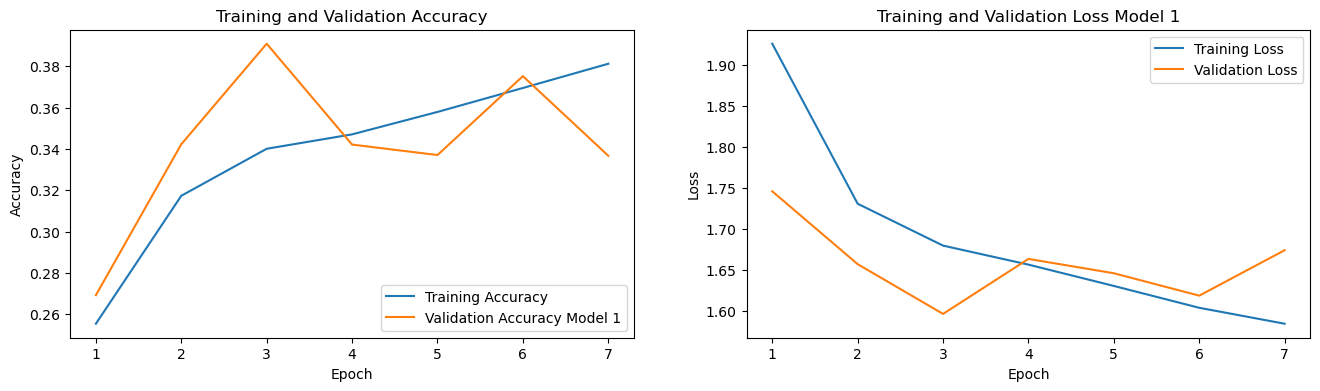

In [140]:
# Get the accuracy and loss values from the training history
train_acc = history_model1.history['accuracy']
val_acc = history_model1.history['val_accuracy']
train_loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy Model 1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 1')

# Display the figure
plt.show()


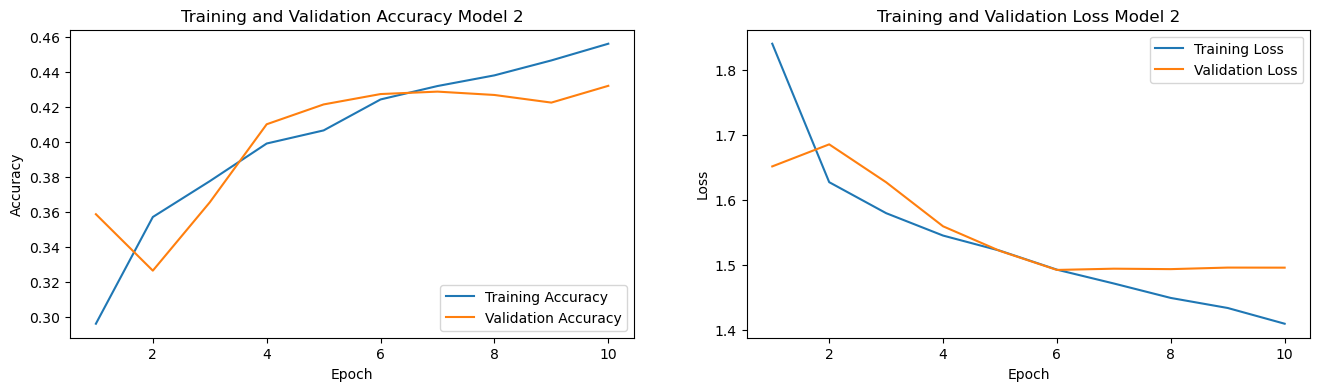

In [139]:
# Get the accuracy and loss values from the training history
train_acc = history_model2.history['accuracy']
val_acc = history_model2.history['val_accuracy']
train_loss = history_model2.history['loss']
val_loss = history_model2.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 2')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 2')

# Display the figure
plt.show()


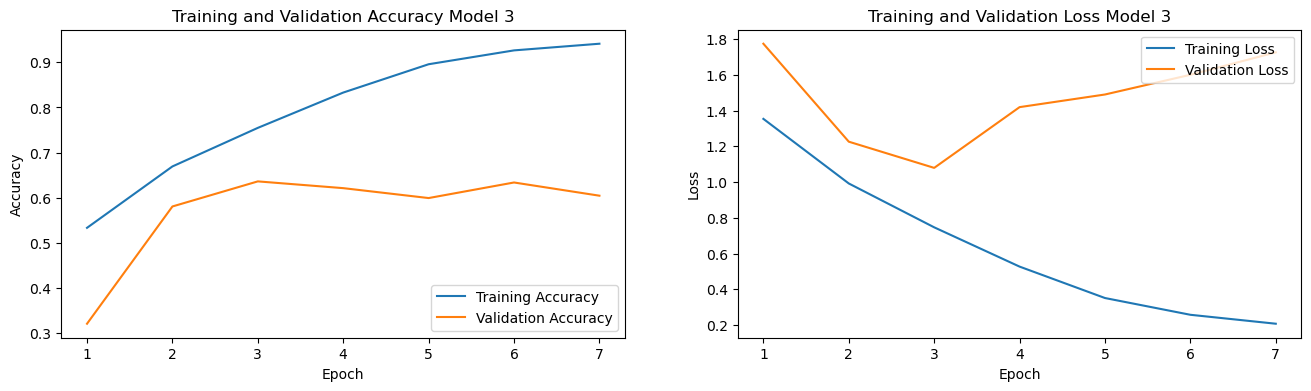

In [138]:
# Get the accuracy and loss values from the training history
train_acc = history_model3.history['accuracy']
val_acc = history_model3.history['val_accuracy']
train_loss = history_model3.history['loss']
val_loss = history_model3.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 3')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 3')

# Display the figure
plt.show()


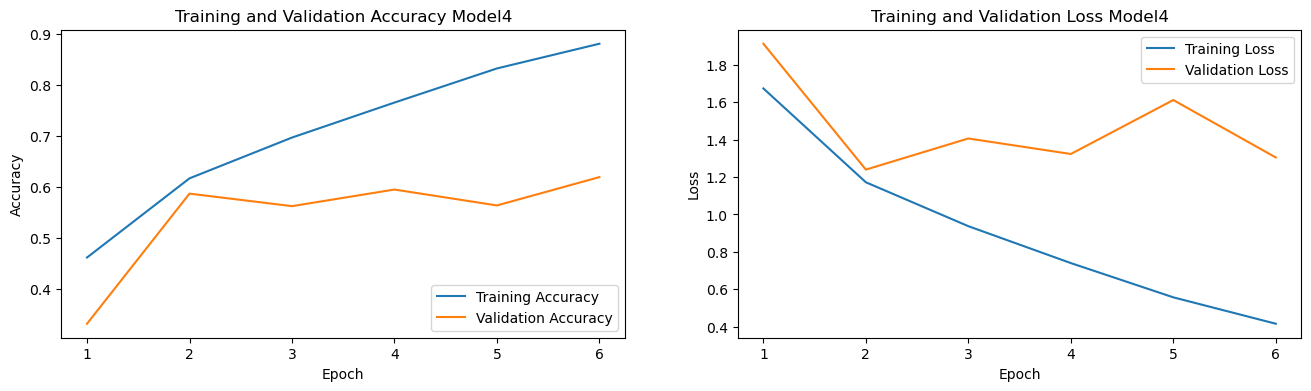

In [137]:
# Get the accuracy and loss values from the training history
train_acc = history_model4.history['accuracy']
val_acc = history_model4.history['val_accuracy']
train_loss = history_model4.history['loss']
val_loss = history_model4.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model4')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model4')

# Display the figure
plt.show()


225/225 [==============================] - 25s 109ms/step - loss: 1.2445 - accuracy: 0.5816


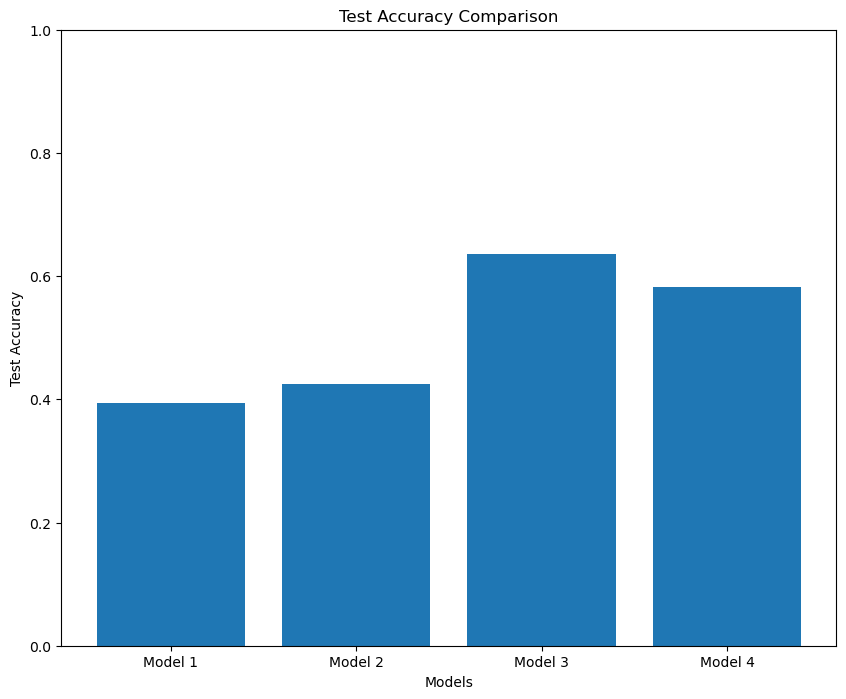

In [103]:

# Evaluate model 1
test_loss1, test_accuracy1 = model1.evaluate(test_generator)

# Evaluate model 2
test_loss2, test_accuracy2 = model2.evaluate(test_generator)

# Evaluate model 3
test_loss3, test_accuracy3 = model3.evaluate(test_generator)

# Evaluate model 4
test_loss4, test_accuracy4 = model4.evaluate(test_generator)

# Create a bar plot for test accuracy
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
test_accuracies = [test_accuracy1, test_accuracy2, test_accuracy3, test_accuracy4]

plt.figure(figsize=(10, 8))
plt.bar(models, test_accuracies)
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])
plt.show()


In [104]:
# Generate predictions for model 1
model1_predictions = model1.predict(test_generator)
model1_predicted_labels = np.argmax(model1_predictions, axis=1)

# Generate predictions for model 2
model2_predictions = model2.predict(test_generator)
model2_predicted_labels = np.argmax(model2_predictions, axis=1)

# Generate predictions for model 3
model3_predictions = model3.predict(test_generator)
model3_predicted_labels = np.argmax(model3_predictions, axis=1)

# Generate predictions for model 4
model4_predictions = model4.predict(test_generator)
model4_predicted_labels = np.argmax(model4_predictions, axis=1)



225/225 [==============================] - 24s 104ms/step


In [107]:
from sklearn.metrics import classification_report

# Calculate performance metrics for model 1
model1_metrics = classification_report(test_generator.classes, model1_predicted_labels, target_names=emotions, zero_division=1)

# Calculate performance metrics for model 2
model2_metrics = classification_report(test_generator.classes, model2_predicted_labels, target_names=emotions, zero_division=1)

# Calculate performance metrics for model 3
model3_metrics = classification_report(test_generator.classes, model3_predicted_labels, target_names=emotions, zero_division=1)

# Calculate performance metrics for model 4
model4_metrics = classification_report(test_generator.classes, model4_predicted_labels, target_names=emotions, zero_division=1)


# Print performance metrics for each model
print("Model 1 Metrics:")
print(model1_metrics)

print("Model 2 Metrics:")
print(model2_metrics)

print("Model 3 Metrics:")
print(model3_metrics)

print("Model 4 Metrics:")
print(model4_metrics)


Model 1 Metrics:
              precision    recall  f1-score   support

       angry       0.36      0.11      0.16       958
   disgusted       1.00      0.00      0.00       111
     fearful       0.32      0.10      0.15      1024
       happy       0.43      0.73      0.54      1774
     neutral       0.37      0.28      0.32      1233
         sad       0.31      0.43      0.36      1247
   surprised       0.53      0.52      0.52       831

    accuracy                           0.39      7178
   macro avg       0.47      0.31      0.29      7178
weighted avg       0.39      0.39      0.35      7178

Model 2 Metrics:
              precision    recall  f1-score   support

       angry       0.40      0.10      0.16       958
   disgusted       1.00      0.00      0.00       111
     fearful       0.32      0.11      0.16      1024
       happy       0.49      0.73      0.59      1774
     neutral       0.43      0.32      0.37      1233
         sad       0.30      0.50      0.38 

### **Visualize a few test images with their predicted classes for Model 3**

1/1 [==============================] - 0s 44ms/step


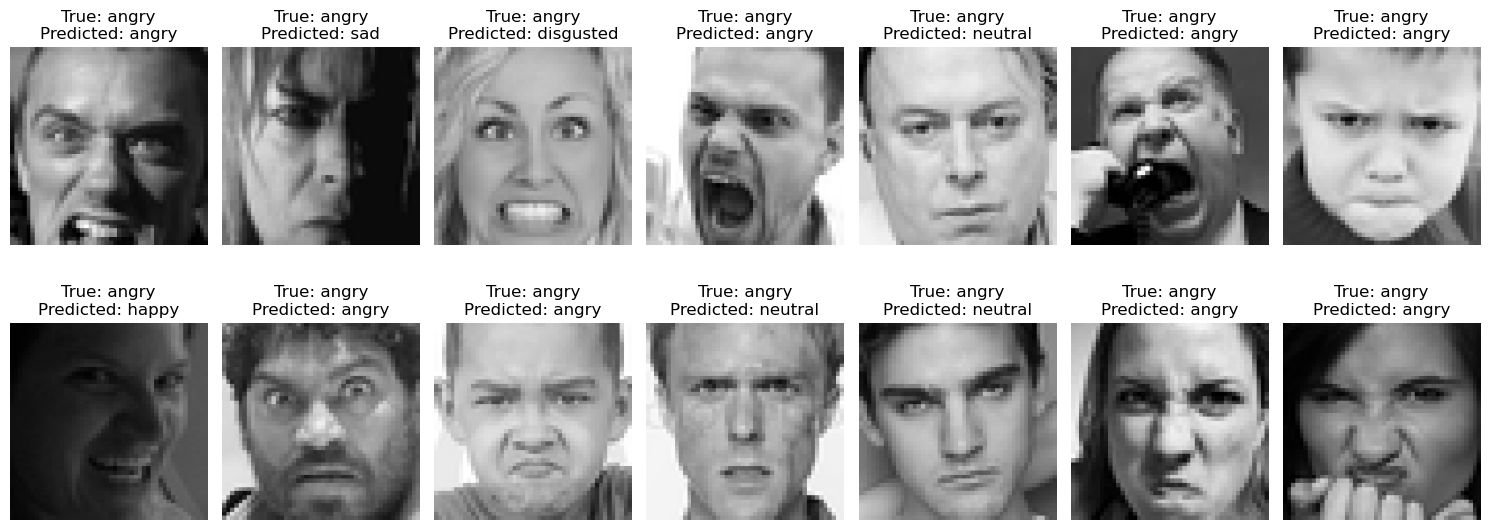

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Get test images and their corresponding labels
test_images = test_generator[0][0]
test_labels = test_generator[0][1]
predicted_labels = model3.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Define the class labels
class_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Select 14 random images to visualize
num_images = 14
random_indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Plot the test images with their predicted classes
fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i, index in enumerate(random_indices):
    img = test_images[index]
    label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]
    
    row = i // 7
    col = i % 7
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {label}\nPredicted: {predicted_label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [126]:
# Create a dictionary to store the indices of each class
class_indices = {}
for i, class_name in enumerate(test_generator.class_indices.keys()):
    class_indices[i] = np.where(true_classes == i)[0]
    print(f"Class {class_name} has {len(class_indices[i])} images in the test set")

Class angry has 192 images in the test set
Class disgusted has 32 images in the test set
Class fearful has 0 images in the test set
Class happy has 0 images in the test set
Class neutral has 0 images in the test set
Class sad has 0 images in the test set
Class surprised has 0 images in the test set


### **TRANSFER LEARNING USING ResNet50 TECHNIQUE**